## CSV 1 - CONSUMO ENERGIA


### VARIÁVEIS CATEGÓRICAS

DATA; ENERGIA ELETRICA EM KWH

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns

sns.set_context('notebook')
sns.set_style('darkgrid')


In [160]:
data = 'ipeadata_consumo_energia.csv'

In [161]:
# read the data from a csv file into a pandas dataframe remove the first row and the last column
df = pd.read_csv(data, sep=';', skiprows=0)

In [192]:
print(df.isnull().values.any())

False


In [162]:
data_dia = pd.Series(df['Data'])
consumo = pd.Series(df['Energia elétrica - consumo - residência - quantidade - GWh - Eletrobras - ELETRO12_CEERES12'])

df = pd.DataFrame({'Data': data_dia, 'Consumo': consumo})



In [163]:
df.head()

,Data,Consumo
0,1976.01,"1259,8"
1,1976.02,"1161,6"
2,1976.03,"1191,6"
3,1976.04,"1180,4"
4,1976.05,"1205,2"


In [164]:
df["Data"] = df["Data"].astype(str)

In [165]:
df[['Ano', 'Mes']] = df['Data'].str.split('.', expand=True)


In [166]:
df['AnoMes'] = pd.to_datetime(df['Ano'] + df['Mes'], format='%Y%m')
df['AnoMes'].dtype

dtype('<M8[ns]')

In [167]:
# set the index of the dataframe to be the column 'AnoMes'
df.set_index('AnoMes', inplace=True)

In [168]:
df.head()

,Data,Consumo,Ano,Mes
AnoMes,,,,
1976-01-01,1976.01,"1259,8",1976,01
1976-02-01,1976.02,"1161,6",1976,02
1976-03-01,1976.03,"1191,6",1976,03
1976-04-01,1976.04,"1180,4",1976,04
1976-05-01,1976.05,"1205,2",1976,05


In [169]:
df.drop('Data', axis=1, inplace=True)

In [170]:
#create a filter that will convert the , to . and then convert the column to flo
df['Consumo'] = df['Consumo'].str.replace(',', '.').astype(float)

In [171]:
df['Consumo'].dtype

dtype('float64')

In [172]:
# convert the column anomes to a datetime object
df.index = pd.to_datetime(df.index)

In [174]:
df['Ano'] = pd.to_numeric(df['Ano'])
df['Mes'] = pd.to_numeric(df['Mes'])

In [175]:
df.dtypes

Consumo    float64
Ano          int64
Mes          int64
dtype: object

In [177]:
print(df["Consumo"].mean())

6302.118425760286


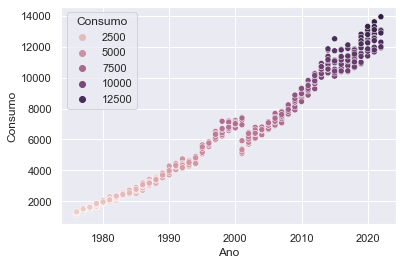

In [187]:
sns.scatterplot(x='Ano', y='Consumo', data=df, hue='Consumo', sizes=(20, 200));



<AxesSubplot:ylabel='Frequency'>

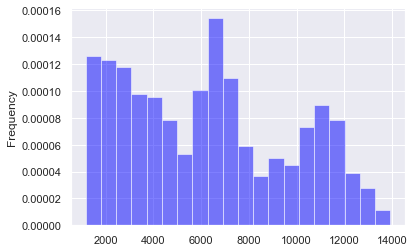

In [178]:
df['Consumo'].plot(kind='hist', bins=20, density=True, alpha=0.5, color='blue')

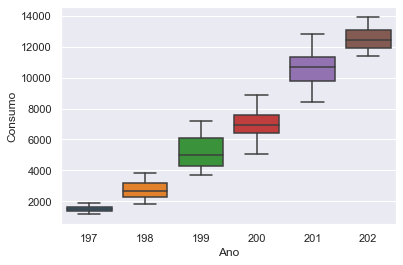

In [195]:
sns.boxplot(x=df['Ano']//10, y='Consumo', data=df);

In [ ]:
df.boxplot(return_type='axes')

# ... and find the p-value:
t, pVal = stats.ttest_ind(, obese)
if pVal < 0.05:
    print('There is a significant difference: p = {0}'.format(pVal))